#<font color='#d25a5a'> **Aduleration detection form Meat images** 🍖 🔎




---
##                 BY: Zitouni Hajer IDS4

---



* <font color='#e3a3b2'> **INTRODUCTION:**   

In the food industry, ensuring the authenticity and quality of meat products is crucial for consumer safety and satisfaction. Meat adulteration, which involves the addition of foreign substances to meat products, poses a significant threat to food integrity. Detecting adulterated meat efficiently and accurately is a challenging task that demands advanced technological solutions.

  *  <font color='#e3a3b2'>**SOLUTION:**💡
  
 ▶  To solve the above drawbacks we've worked on this project which leverages deep learning techniques to address this challenge by using a Convolutional Neural Network (CNN) based autoencoder.

In [ ]:
from google.colab import drive

# Montez Google Drive en exécutant cette cellule
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install Pillow

* <font color='#e3a3b2'> **DATASET:**  

The dataset used in this project consists of images of meat, categorized into two classes:

* **Unadulterated Meat:** Images of pure, unaltered meat.
* **Adulterated Meat:** Images of meat that have been tampered with or contain foreign substances.


* replace images .jfif in .png so we can explore and use them lately:

In [ ]:
from PIL import Image
import os
import tensorflow as tf


# Définir le répertoire contenant les images .jfif
directories = ['/content/drive/MyDrive/dataset/adulterated', '/content/drive/MyDrive/dataset/unadulterated']

for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith('.jfif'):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            new_filename = filename.replace('.jfif', '.png')
            img.save(os.path.join(directory, new_filename))
            os.remove(img_path)


* Load our dataset into train dataset 80% and validation dataset 20%:

In [ ]:
dataset_directory='/content/drive/MyDrive/dataset'
# Charger l'ensemble d'entraînement
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary'
)

# Charger l'ensemble de validation
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary'
)


Found 94 files belonging to 2 classes.
Using 76 files for training.
Found 94 files belonging to 2 classes.
Using 18 files for validation.


* Divide the dataset into normal train and validation datasets which contain just unadulterated images and anomalous train and validation datasets for adulterated images and normalize them:


In [ ]:
import tensorflow as tf

def extract_images_labels(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.extend(image_batch)
        labels.extend(label_batch)
    return tf.stack(images), tf.stack(labels)

train_images, train_labels = extract_images_labels(train_dataset)

validation_images, validation_labels = extract_images_labels(validation_dataset)

# Prepare the data for anomaly detection
train_images = train_images.numpy().astype(float)
validation_images = validation_images.numpy().astype(float)

min_val = tf.reduce_min(train_images)
max_val = tf.reduce_max(train_images)
train_images = (train_images - min_val) / (max_val - min_val)
validation_images = (validation_images - min_val) / (max_val - min_val)

train_images = tf.cast(train_images, tf.float32)
validation_images = tf.cast(validation_images, tf.float32)

train_labels = tf.cast(train_labels[:, 0], bool)
validation_labels = tf.cast(validation_labels[:, 0], bool)

# Extract normal and anomalous data
normal_train_data = train_images[train_labels]
anomalous_train_data = train_images[~train_labels]

normal_validation_data = validation_images[validation_labels]
anomalous_validation_data = validation_images[~validation_labels]


* Load the data into adulterated and unadulterated datasets to use the to visualize some images:

In [ ]:
# Charger les datasets complets pour l'évaluation

adulterated_directory='/content/drive/MyDrive/dataset/adulterated'
unadulterated_directory= '/content/drive/MyDrive/dataset/unadulterated'

adulterated_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    adulterated_directory,
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False
)

unadulterated_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    unadulterated_directory,
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False
)

Found 49 files belonging to 1 classes.
Found 45 files belonging to 1 classes.


In [ ]:
import matplotlib.pyplot as plt
import random

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_adulterated_dataset = adulterated_dataset.map(lambda x: (normalization_layer(x), normalization_layer(x)))
normalized_unadulterated_dataset = unadulterated_dataset.map(lambda x: (normalization_layer(x), normalization_layer(x)))


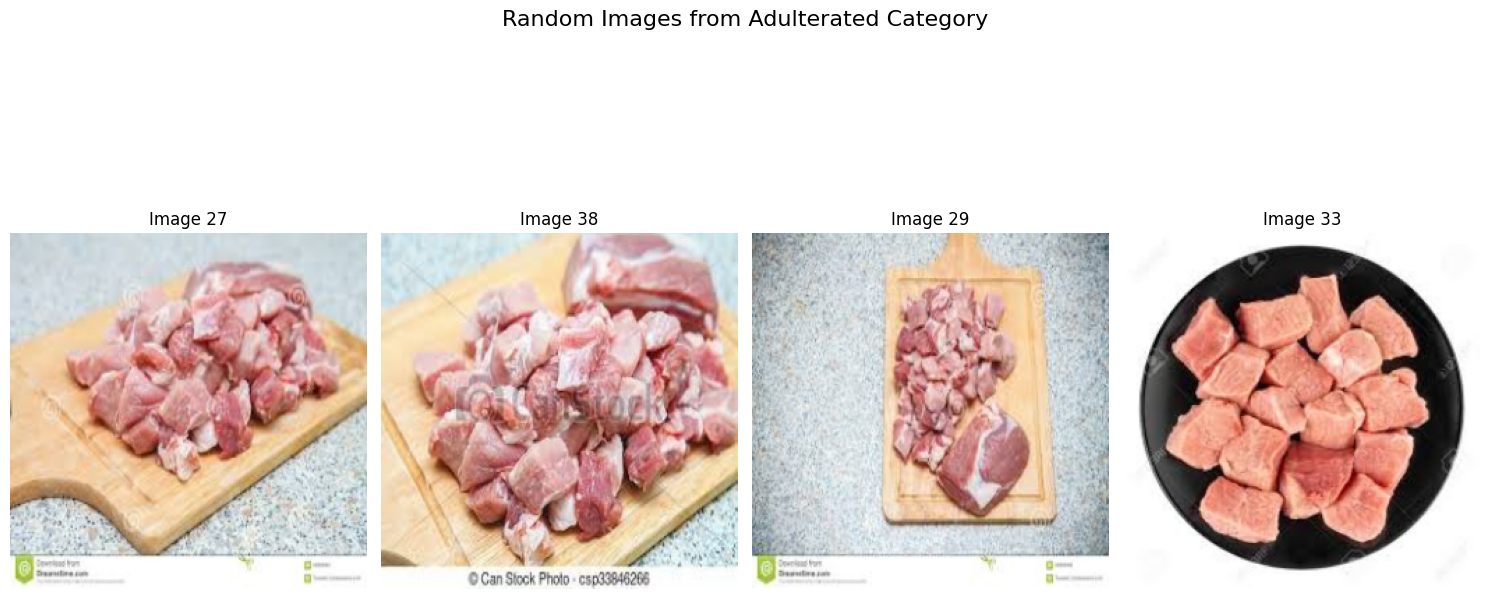

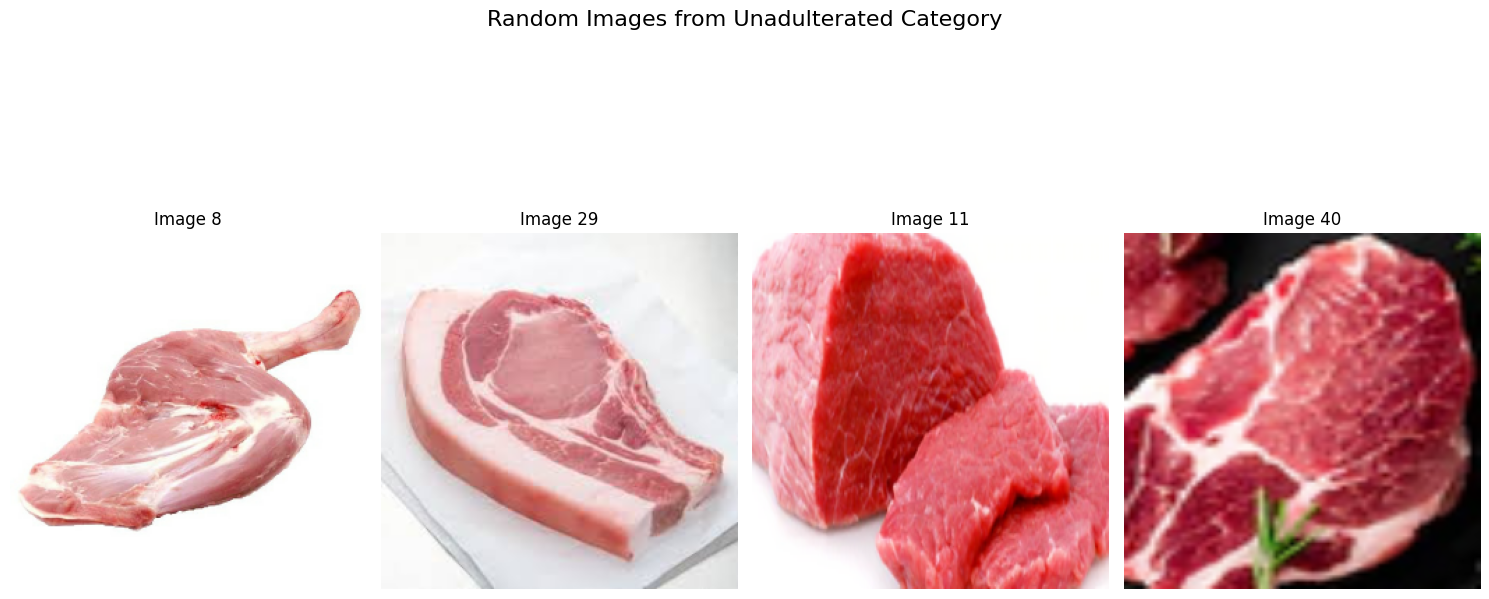

In [ ]:
import matplotlib.pyplot as plt
import random

import matplotlib.pyplot as plt
import random

def visualize_random_images(dataset, category_name):
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    fig.suptitle(f"Random Images from {category_name} Category", fontsize=16)

    for i, idx in enumerate(random.sample(range(40), 4)):
        col = i % 4
        for images, _ in dataset.take(1).as_numpy_iterator():
            axes[col].imshow(images[i])
            axes[col].set_title(f"Image {idx + 1}")
            axes[col].axis("off")

    plt.tight_layout()
    plt.show()

# Utilisation de la fonction visualize_random_images
visualize_random_images(normalized_adulterated_dataset, "Adulterated")
visualize_random_images(normalized_unadulterated_dataset, "Unadulterated")


* This is an additional code we tried to use and to run to augment our dataset but it doesn't work caused some errors in execution and we couldn't fix it:

In [ ]:
import random

def random_flip(image):
  """Flips the image horizontally or vertically with a random probability."""
  if random.random() < 0.5:
    return tf.image.flip_left_right(image)
  elif random.random() < 0.5:
    return tf.image.flip_up_down(image)
  return image

def random_noise(image, noise_factor=0.1):
  """Adds random Gaussian noise to an image."""
  noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_factor, dtype=tf.float32)
  return image + noise
 if augment:
    dataset = dataset.map(lambda x, y: (random_flip(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply random flip
    dataset = dataset.map(lambda x, y: (x, random_noise(y, noise_factor=0.1)), num_parallel_calls=tf.data.AUTOTUNE)  # Add random noise


  *  <font color='#e3a3b2'>**AUTOENCODER IMPLEMETATION**

---
In this code, we built and trained a convolutional autoencoder for anomaly detection using unadulterated meat images. We defined the autoencoder architecture with separate encoder and decoder parts, converted the training and validation data into TensorFlow datasets, and trained the model while using early stopping to prevent overfitting. Finally, we visualized the training and validation loss to evaluate the model's performance.






Epoch 1/50
2/2 [==============================] - 16s 1s/step - loss: 0.1158 - val_loss: 0.0807
Epoch 2/50
2/2 [==============================] - 12s 1s/step - loss: 0.0766 - val_loss: 0.1162
Epoch 3/50
2/2 [==============================] - 13s 1s/step - loss: 0.1164 - val_loss: 0.0916
Epoch 4/50
2/2 [==============================] - 12s 1s/step - loss: 0.0901 - val_loss: 0.0648
Epoch 5/50
2/2 [==============================] - 13s 1s/step - loss: 0.0626 - val_loss: 0.0596
Epoch 6/50
2/2 [==============================] - 12s 1s/step - loss: 0.0570 - val_loss: 0.0583
Epoch 7/50
2/2 [==============================] - 13s 1s/step - loss: 0.0543 - val_loss: 0.0618
Epoch 8/50
2/2 [==============================] - 13s 1s/step - loss: 0.0555 - val_loss: 0.0456
Epoch 9/50
2/2 [==============================] - 13s 1s/step - loss: 0.0429 - val_loss: 0.0427
Epoch 10/50
2/2 [==============================] - 13s 3s/step - loss: 0.0392 - val_loss: 0.0485
Epoch 11/50
2/2 [======================

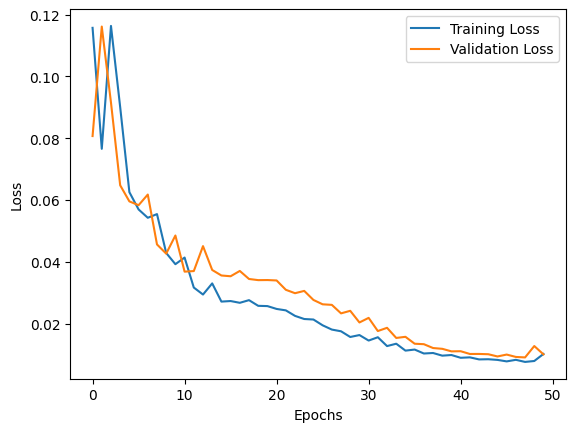

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


def build_autoencoder(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoded)
    return autoencoder

def to_tf_dataset(data, batch_size=32, augment=False):
  """Converts data to tf.data.Dataset with optional data augmentation."""
  dataset = tf.data.Dataset.from_tensor_slices((data, data))
  dataset = dataset.batch(batch_size)
  return dataset


# Function to train the autoencoder
def train_autoencoder(autoencoder, train_dataset, validation_dataset, epochs=50, batch_size=16):
    autoencoder.compile(optimizer='Adam', loss=MeanSquaredError())

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping])

    return history

input_shape = (256, 256, 3)
autoencoder = build_autoencoder(input_shape)

normal_train_dataset = to_tf_dataset(normal_train_data)
normal_validation_dataset = to_tf_dataset(normal_validation_data)


history = train_autoencoder(autoencoder, normal_train_dataset, normal_validation_dataset, epochs=50)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


 ## **Reconstruction Error Calculation**

 we computed the reconstruction error for each image to assess the performance of our autoencoder. We defined a function to calculate the reconstruction error, created tf.data.Dataset objects for normal and anomalous validation data, and computed the reconstruction errors for both datasets. Finally, we compared the mean reconstruction errors for normal and anomalous data to evaluate the model's ability to detect anomalies.

In [ ]:
import numpy as np
# Calculate reconstruction error for each image
def compute_reconstruction_error(model, dataset):
    errors = []
    for batch in dataset.batch(32):
        reconstructed = model.predict(batch)
        batch_errors = tf.reduce_mean(tf.square(batch - reconstructed), axis=[1, 2, 3])
        errors.extend(batch_errors.numpy())
    return np.array(errors)

normal_validation_dataset = tf.data.Dataset.from_tensor_slices(normal_validation_data)
anomalous_validation_dataset = tf.data.Dataset.from_tensor_slices(anomalous_validation_data)

normal_errors = compute_reconstruction_error(autoencoder, normal_validation_dataset)
anomalous_errors = compute_reconstruction_error(autoencoder, anomalous_validation_dataset)

print("Mean reconstruction error for normal validation data:", np.mean(normal_errors))
print("Mean reconstruction error for anomalous validation data:", np.mean(anomalous_errors))


1/1 [==============================] - 1s 956ms/step
Mean reconstruction error for normal validation data: 0.010039213
Mean reconstruction error for anomalous validation data: 0.014900516


## **Interpretaion:**

* **Reconstruction Error:** The reconstruction error is a measure of how well the autoencoder can recreate the input data. A lower error indicates that the autoencoder is accurately reconstructing the input, while a higher error suggests poorer reconstruction.

* **Normal Data:** The mean reconstruction error for normal (unadulterated) validation data is approximately 0.0100. This low error suggests that the autoencoder is effectively reconstructing normal images, as expected since it was trained on unadulterated data.

* **Anomalous Data:** The mean reconstruction error for anomalous (adulterated) validation data is approximately 0.0149. This higher error indicates that the autoencoder struggles to accurately reconstruct adulterated images, as it has not been trained on these types of images.

**CONCLUSION:**

The difference in mean reconstruction errors between normal and anomalous data demonstrates the autoencoder's ability to detect anomalies. Since the reconstruction error for anomalous data is higher than that for normal data, it suggests that the autoencoder can distinguish between unadulterated and adulterated meat images. This difference can be used as a threshold for identifying anomalies in new data: images with a reconstruction error significantly higher than the normal error could be flagged as potentially adulterated.

## **Metrics**

this code predicts reconstruction errors for normal training data using an autoencoder and calculates the mean absolute error (MAE). It sets a threshold based on the mean training loss to distinguish between normal and adulterated images. Predictions are made by comparing the reconstruction errors of validation images to this threshold. Finally, the code evaluates the model's performance using accuracy, precision, recall, and F1 score metrics.

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
train_loss

train_loss_mean = tf.reduce_mean(train_loss)  # Reduce mean across all elements


threshold = train_loss_mean
#threshold = np.mean(train_loss) + 0.5
print("Threshold: ", threshold)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  predictions = tf.math.less(loss, threshold)

  return predictions

preds = predict(autoencoder, validation_images, threshold)

flat_preds = preds.numpy().flatten().astype(int)
flat_labels = np.array(validation_labels).astype(int)
flat_preds = flat_preds[:flat_labels.shape[0]]
flat_labels = np.array(validation_labels).reshape(-1)[:flat_preds.shape[0]]

accuracy = accuracy_score(flat_labels, flat_preds)
precision = precision_score(flat_labels, flat_preds)
recall = recall_score(flat_labels, flat_preds)
f1 = f1_score(flat_labels, flat_preds)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



2/2 [==============================] - 5s 129ms/step
Threshold:  tf.Tensor(0.1269049, shape=(), dtype=float32)
Accuracy: 0.6111111111111112
Precision: 0.6666666666666666
Recall: 0.8333333333333334
F1 Score: 0.7407407407407408


---
The results indicate that the autoencoder model was able to achieve the following performance metrics for detecting adulterated meat images:

1. **Threshold**: The mean reconstruction error for normal training data was 0.1269, which was set as the threshold for classifying an image as normal or adulterated.

2. **Accuracy**: The model's accuracy was 61.11%, meaning that 61.11% of the validation images were correctly classified as either normal or adulterated.

3. **Precision**: The precision was 66.67%, indicating that out of all the images classified as adulterated, 66.67% were actually adulterated.

4. **Recall**: The recall was 83.33%, suggesting that the model correctly identified 83.33% of the adulterated images in the validation set.

5. **F1 Score**: The F1 Score, which is the harmonic mean of precision and recall, was 74.07%. This indicates a good balance between precision and recall, highlighting the model's effectiveness in detecting adulterated images.

Overall, the model shows promise in identifying adulterated meat images, with particularly strong performance in recall, though there is room for improvement in accuracy and precision.

## **Adulterated Detection test:**

In [ ]:
def anomaly_score(data):
    encoded_data = autoencoder(data)  # Pass data through the entire model (encoder & decoder)
    reconstruction_error = tf.reduce_mean(tf.abs(data - encoded_data), axis=(1, 2, 3))
    return reconstruction_error

new_meat_image = anomalous_validation_data[5]
new_meat_image = np.expand_dims(new_meat_image, axis=0)  # Add a new dimension for batch size

anomaly_score = anomaly_score(new_meat_image)
print(anomaly_score)
print(threshold)
# Classify image based on anomaly score
if anomaly_score > threshold:
  print("This image might be adulterated (high anomaly score).")
else:
  print("This image seems normal (low anomaly score).")

tf.Tensor([0.0690848], shape=(1,), dtype=float32)
tf.Tensor(0.06566737, shape=(), dtype=float32)
This image might be adulterated (high anomaly score).




---



---
# **Another examples of encoders trained with differents (loss functions, layers, optimizer or learning rates)**


Epoch 1/50
2/2 [==============================] - 21s 3s/step - loss: 0.1117 - val_loss: 0.0722
Epoch 2/50
2/2 [==============================] - 13s 2s/step - loss: 0.0739 - val_loss: 0.1153
Epoch 3/50
2/2 [==============================] - 15s 1s/step - loss: 0.1190 - val_loss: 0.0743
Epoch 4/50
2/2 [==============================] - 14s 1s/step - loss: 0.0735 - val_loss: 0.0660
Epoch 5/50
2/2 [==============================] - 14s 3s/step - loss: 0.0633 - val_loss: 0.0639
Epoch 6/50
2/2 [==============================] - 14s 2s/step - loss: 0.0618 - val_loss: 0.0720
Epoch 7/50
2/2 [==============================] - 14s 1s/step - loss: 0.0687 - val_loss: 0.0557
Epoch 8/50
2/2 [==============================] - 14s 1s/step - loss: 0.0529 - val_loss: 0.0490
Epoch 9/50
2/2 [==============================] - 15s 1s/step - loss: 0.0462 - val_loss: 0.0523
Epoch 10/50
2/2 [==============================] - 14s 3s/step - loss: 0.0465 - val_loss: 0.0425
Epoch 11/50
2/2 [======================

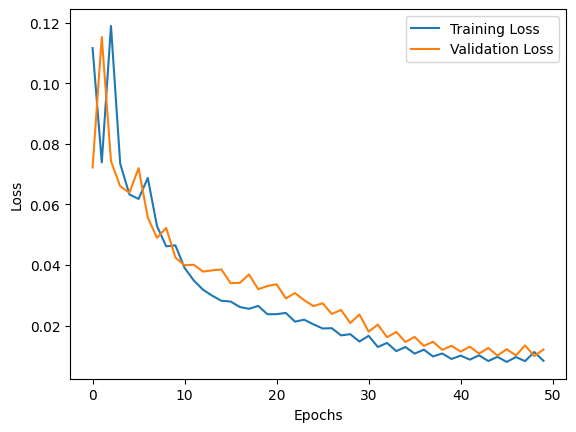

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def build_autoencoder(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoded)
    return autoencoder

def to_tf_dataset(data, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((data, data))
    dataset = dataset.batch(batch_size)
    return dataset

def train_autoencoder(autoencoder, train_dataset, validation_dataset, epochs=50, batch_size=64):
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping])

    return history

input_shape = (256, 256, 3)
autoencoder = build_autoencoder(input_shape)

normal_train_dataset = to_tf_dataset(normal_train_data)
normal_validation_dataset = to_tf_dataset(normal_validation_data)

history = train_autoencoder(autoencoder, normal_train_dataset, normal_validation_dataset, epochs=50)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  predictions = tf.math.less(loss, threshold)

  return predictions

preds = predict(autoencoder, validation_images, threshold)

flat_preds = preds.numpy().flatten().astype(int)
flat_labels = np.array(validation_labels).astype(int)
flat_preds = flat_preds[:flat_labels.shape[0]]
flat_labels = np.array(validation_labels).reshape(-1)[:flat_preds.shape[0]]

accuracy = accuracy_score(flat_labels, flat_preds)
precision = precision_score(flat_labels, flat_preds)
recall = recall_score(flat_labels, flat_preds)
f1 = f1_score(flat_labels, flat_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.6111111111111112
Precision: 0.6470588235294118
Recall: 0.9166666666666666
F1 Score: 0.7586206896551724




---



---

# **example in which we tried to augment the data while loading it**

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
batch_size = 4
image_size = (128, 128)
input_shape = (128, 128, 3)  # Assuming RGB images

# Data preparation
train_data_dir = '/content/drive/MyDrive/dataset'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    subset='validation'
)

Found 76 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [ ]:


def build_autoencoder(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = build_autoencoder(input_shape)


autoencoder.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the model
autoencoder.save("autoencoder_model.h5")


# **Images reconstruction from autoencoder**

1/1 [==============================] - 1s 1s/step


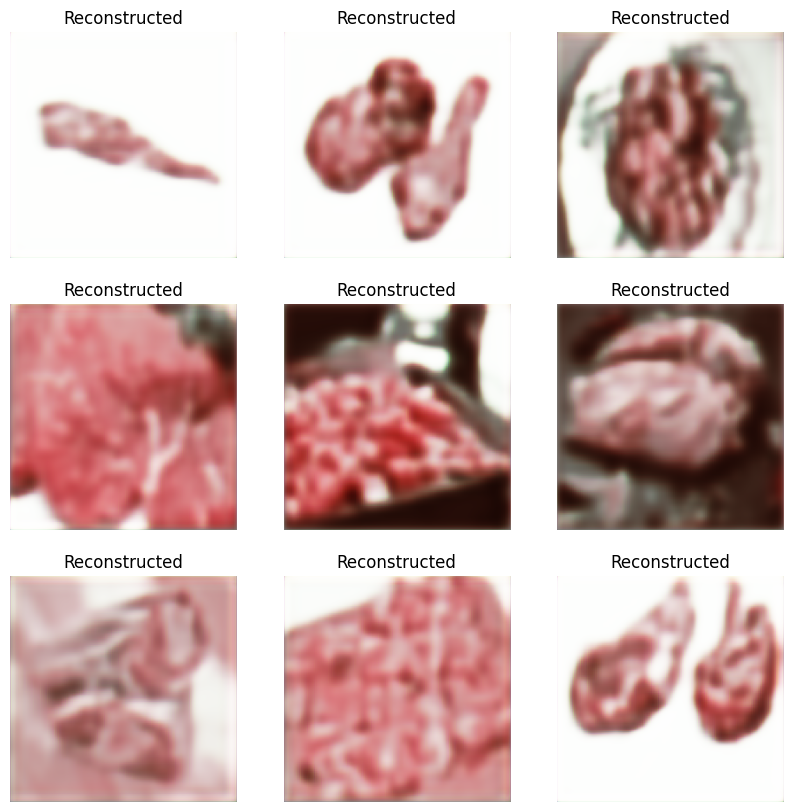

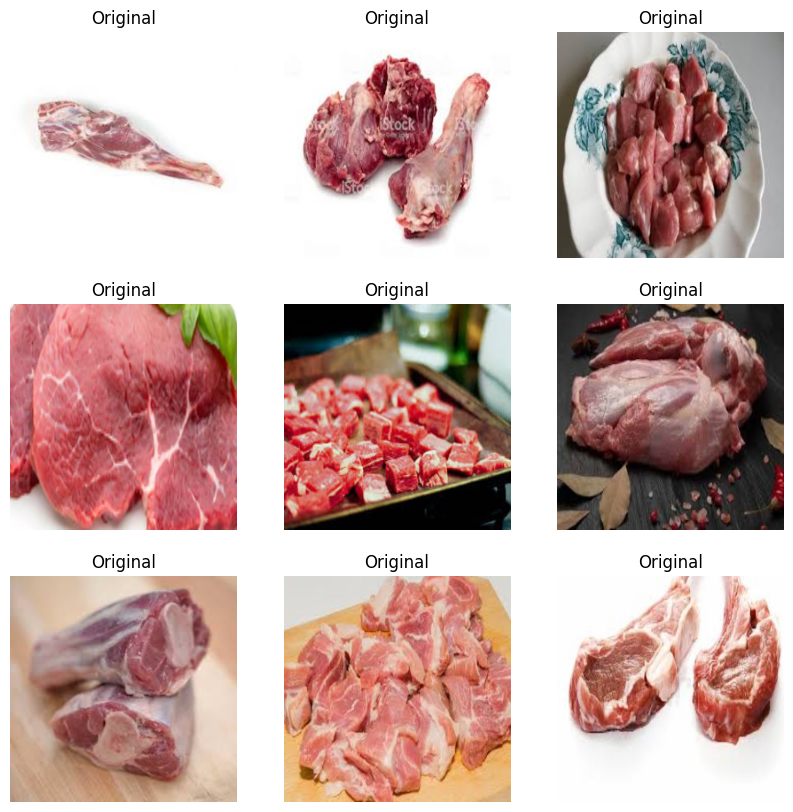

In [ ]:
normal_validation_dataset = tf.data.Dataset.from_tensor_slices(normal_validation_data).batch(32)

# Visualize reconstructed and original images
for batch in normal_validation_dataset.take(1):
    reconstructed_images = autoencoder.predict(batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i])
        plt.title("Original")
        plt.axis("off")
    plt.show()
